In [1]:
using Dates, DataFrames, LinearAlgebra, DynamicalSystems, CSV, Plots, UnicodePlots, Statistics, DataStructures, JLD, Plots.PlotMeasures, LaTeXStrings, Distributions, Random, StatsBase, KernelDensity, Interpolations, StatsPlots, ColorSchemes, Measures

path_to_files = "/home/matt/Desktop/Advanced_Analytics/Dissertation/Code/MDTG-MALABM/"
include(path_to_files * "Scripts/Moments.jl"); 


## Read rl results data

In [ ]:
# read in the type 1 agents data
t1_b1_s0 = load("../Data/RL/Training/MARL/Results_Type1_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];
t1_b0_s1 = load("../Data/RL/Training/MARL/Results_Type1_Buy_0_Sell_1_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];
t1_b1_s1 = load("../Data/RL/Training/MARL/Results_Type1_Buy_1_Sell_1_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];
t1_b0_s5 = load("../Data/RL/Training/MARL/Results_Type1_Buy_0_Sell_5_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];
t1_b5_s5 = load("../Data/RL/Training/MARL/Results_Type1_Buy_5_Sell_5_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];


In [ ]:
# read in the type 2 agents data
t2_b1_s0 = load("../Data/RL/Training/MARL/Results_Type2_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];
t2_b1_s1 = load("../Data/RL/Training/MARL/Results_Type2_Buy_1_Sell_1_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];
t2_b5_s0 = load("../Data/RL/Training/MARL/Results_Type2_Buy_5_Sell_0_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];
t2_b5_s5 = load("../Data/RL/Training/MARL/Results_Type2_Buy_5_Sell_5_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];


In [ ]:
# read in combined data
t1_b0_s1_t2_b1_s0 = load("../Data/RL/Training/MARL/Results_Type1_Buy_0_Sell_1_Type2_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];


In [ ]:
marl_data = Dict("I+" => t1_b1_s0, "I-" => t1_b0_s1, "I+_I-" => t1_b1_s1, "II+" => t2_b1_s0,
    "II+_II-" => t2_b1_s1, "II+_I-" => t1_b0_s1_t2_b1_s0, "5I-" => t1_b0_s5, "5II+" => t2_b5_s0, 
    "5I+_5I-" => t1_b5_s5, "5II+_5II-" => t2_b5_s5);


## Auxilary functions

In [2]:
function CreateCombinations(types::Vector{Int64}, numType1Buyers::Int64, numType1Sellers::Int64, numType2Buyers::Int64, numType2Sellers::Int64)
    raw_data_dir = path_to_files * "/Data/CoinTossX/MARL/"
    if 1 in types
        raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 1, types)][1]) * "_Buy_" * string(numType1Buyers) * "_Sell_" * string(numType1Sellers) * "_"
    end
    if 2 in types
        raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 2, types)][1]) * "_Buy_" * string(numType2Buyers) * "_Sell_" * string(numType2Sellers) * "_"
    end
    raw_data_dir = raw_data_dir * "alpha0.1_lambda0.003_gamma0.25"
    if 2 in types
        raw_data_dir = raw_data_dir * "_delta_3_6"
    end
    return raw_data_dir
end

CreateCombinations (generic function with 1 method)

## Reward convergence

In [ ]:
function Winsorise(data::Vector{Float64}, tol::Float64)
    return data[findall(x -> x < quantile(data, 1-tol) && x > quantile(data, tol), data)]
end

In [ ]:
function ExponentialMovingAverage(data::Vector{Float64}, alpha::Float64)
    s = Vector{Float64}()
    push!(s, data[1])
    for i in 2:length(data)
        push!(s, alpha * data[i] + (1-alpha) * s[i-1])
    end
    return s
end

In [ ]:
function RewardConvergence(marl_data, tol, alpha)
    plots = Dict()
    for (j, key) in enumerate(keys(marl_data))
        res = marl_data[key]
        num_episodes = length(res)
        labels = Set{String}()
        for (k, agent) in enumerate(keys(res[1]))
            if "AgentType" in keys(res[k][agent])
                agent_la_type = res[k][agent]["AgentType"]
            else
                agent_la_type = "Type1"
            end
            agent_la_type == "Type1" ? agent_la_type = "I" : agent_la_type = "II"
            res[k][agent]["ActionType"] == "Buy" ? agent_action_type = "+" : agent_action_type = "-"
            fields = split(key, "_")
            label = fields[1]
            if length(fields) > 1
                fields[1][1] != '5' ? label = "{" * label * "," * fields[2] * "}" : label = label * raw" $\bigcup$ " * fields[2]
                label = agent_la_type * agent_action_type * raw"$\in$" * label
            else
                fields[1][1] != '5' ? label = agent_la_type * agent_action_type * raw"$\in$" * "{" * label * "}" : label = agent_la_type * agent_action_type * raw"$\in$" * label
            end
            if label in labels
                continue
            else
                push!(labels, label)
            end
            if agent_la_type == "I" 
                data = [res[i][agent]["TotalReward"] for i in 1:num_episodes]
                if !("Type1" in keys(plots))
                    p = plot(ExponentialMovingAverage(Winsorise(data, tol), alpha) / (10^4), 
                        xlabel = "Episodes", 
                        title = "Type I",
                        legend = :bottomright, ylabel = raw"Agent Returns [$\times10^{4}$]", label = label, 
                        titlefontsize = 12, 
                        legendfontsize = 8, fg_legend = :transparent, grid = false,
                        fontfamily="Computer Modern")
                    push!(plots, "Type1" => p)
                else
                    plot!(plots["Type1"], ExponentialMovingAverage(Winsorise(data, tol), alpha) / (10^4), 
                        xlabel = "Episodes", 
                    legend = :bottomright, ylabel = raw"Agent Returns [$\times10^{4}$]", label = label, 
                        titlefontsize = 12, 
                    fg_legend = :transparent, grid = false,
                    fontfamily="Computer Modern")
                end
            elseif agent_la_type == "II" 
                data = [res[i][agent]["TotalReward"] for i in 1:num_episodes]
                if !("Type2" in keys(plots))
                    q = plot(ExponentialMovingAverage(Winsorise(data, tol), alpha) / (10^4), 
                        xlabel = "Episodes", 
                        title = "Type II", 
                        legend = :bottomright, ylabel = raw"Agent Returns [$\times10^{4}$]", label = label, 
                        titlefontsize = 12, 
                        legendfontsize = 8, fg_legend = :transparent, grid = false,
                        fontfamily="Computer Modern")
                    push!(plots, "Type2" => q)
                else
                    plot!(plots["Type2"], ExponentialMovingAverage(Winsorise(data, tol), alpha) / (10^4), 
                        xlabel = "Episodes", 
                    legend = :bottomright, ylabel = raw"Agent Returns [$\times10^{4}$]", label = label, 
                        titlefontsize = 12, 
                    legendfontsize = 8, fg_legend = :transparent, grid = false,
                    fontfamily="Computer Modern")
                end
            end
        end
    end
    for key in keys(plots)
#         Plots.savefig(plots[key], "../Images/MARL/Returns_" * key * ".pdf")
        display(plots[key])
    end
end

In [ ]:
winsorise = true
winsorise ? tol = 0.01 : tol = 0.0
moving_average = true
moving_average ? alpha = 0.1 : alpha = 1.0
RewardConvergence(marl_data, tol, alpha)

## State space recon

1. The amount of transient effects the embedding a bit but not by much if it i below 1000
2. The different smoothing methods and parameters significantly effect tau and the shape of the box-size vs correlation dimension plots, however it does not really effect the outcomes.

In [ ]:
# bin the log returns for smoothing
function SimpleMovingAverage(logreturns, bins)
    logreturns_binned = Vector{Float64}()
    for i in bins:length(logreturns)
        start = (i-bins)+1
        push!(logreturns_binned, mean(logreturns[start:i]))
    end
    return logreturns_binned
end

In [ ]:
function GetTauPlotACF(logreturns, lags)
    return_autocor = autocor(logreturns, lags)
    tau = estimate_delay(logreturns, "ac_min", lags)
    println("Tau: " * string(tau))
    plot(return_autocor, xlabel = "Lags", ylabel = "Autocorrelation", legend = false, fontfamily = "Computer Modern")
    return tau
end

In [ ]:
function LinearRegion(es_log, cs_log; tol = 0.1)
    diffs = diff(cs_log)
    start_ind = findfirst(x -> x > tol, diffs)
    fin_ind = findfirst(x -> x < tol, diffs[start_ind:end])
    if isnothing(fin_ind)
        fin_ind = length(cs_log)
    end
    return start_ind, fin_ind
end

In [ ]:
# compute the GP correlation dimension and use m to compute the required delay dimension
function CorrelationVsBoxSize(data, dims, es_starts, es_stops, es_step, tau, tol, Dmax, plot_slopes)
    
    slopes = Vector{Float64}()
    se_betas = Vector{Float64}()
    
    p = nothing

    for (i, dim) in enumerate(dims)
        # set box size range
        es = ℯ .^ (es_starts[i]:es_step:es_stops[i])
        es_log = log.(es)
        
        # create correlation embeddings
        recon = embed(data, dim, tau)
        cs = correlationsum(recon, es; q = 2)
        cs_log = log.(cs)
        start_ind, fin_ind = LinearRegion(es_log, cs_log; tol = tol)
        if length(cs_log)/2 > length(cs_log[start_ind:fin_ind])
            println("[Warning] Less than a half of the data may be saturated: dim = ", dim)
            println("Fitting to all data, please inspect!")
            start_ind = 1
            fin_ind = length(cs_log)
        end
        lr = linreg(es_log[start_ind:fin_ind], cs_log[start_ind:fin_ind])
        slope = lr[2]
        
        # compute the variance of the slope
        N = length(cs_log)
        sigma_sq = (1/(N-2)) * sum(((lr[1] .+ (lr[2] .* es_log[start_ind:fin_ind])) .- cs_log[start_ind:fin_ind]).^2)
        xbar = mean(es_log[start_ind:fin_ind])
        se_beta = sqrt(sigma_sq / sum((es_log[start_ind:fin_ind] .- xbar).^2))
        
        push!(slopes, slope)
        push!(se_betas, se_beta)
        
        if slope > Dmax
            println("[Warning] Correlation dimension: ", slope, " doesn't have enough data (Dmax = ", Dmax, "), for dim = ",dim)
        end
        
        if plot_slopes
            # make plots
            if i == 1
                p = plot(es_log, cs_log, xlabel = "Box size", ylabel = "Correlation", label = dim, legend = false, linewidth = 1.5, fontfamily = "Computer Modern")
                plot!(p, es_log[start_ind:fin_ind], cs_log[start_ind:fin_ind], linewidth = 1.5, fontfamily = "Computer Modern")
                plot!(es_log, lr[1] .+ (lr[2] .* es_log))
            else
                plot!(p, es_log, cs_log, label = dim, linewidth = 1.5, fontfamily = "Computer Modern")
                plot!(p, es_log[start_ind:fin_ind], cs_log[start_ind:fin_ind], linewidth = 1.5, fontfamily = "Computer Modern")
                plot!(es_log, lr[1] .+ (lr[2] .* es_log))
            end
        end
    end
        
    if plot_slopes
        display(p)
    end
    
    return slopes, se_betas
    
end

In [ ]:
function PlotEmbeddingDimesion(slopes, se_betas, dims)
    lower = slopes .- 1.96 .* se_betas
    upper = slopes .+ se_betas .* 1.96
    plot(dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", legend = false, 
        marker = "o", markersize = 2, markerstrokewidth = 0, 
        fillrange = (lower, upper), fillalpha=0.2, 
        fontfamily = "Computer Modern")
end


In [ ]:
function PlotEmbedding(embedding, case)
    # plot the embedding
    p = plot([x1 for (x1,x2) in embedding] .* 10^5, [x2 for (x1,x2) in embedding] .* 10^5, 
        title = "Embedding: " * case, 
        legend = false, lw = 1, marker = "o", markersize = 0, alpha = 0.5, color = :dodgerblue3, 
        xlabel = raw"X1 [$\times 10^{5}$]", ylabel = raw"X2 [$\times10^{5}$]", grid = false,
        size = (500,500), fontfamily = "Computer Modern")
  display(p)
end

In [ ]:
function PlotEmbedding(embedding, smoothedReturns, indices, case)
    # plot the embedding
    p = plot([x1 for (x1,x2) in embedding] .* 10^5, [x2 for (x1,x2) in embedding] .* 10^5, 
        title = "Embedding: " * case, 
        legend = false, lw = 1, marker = "o", markersize = 0, alpha = 0.5, color = :dodgerblue3, 
        xlabel = raw"X1 [$\times 10^{5}$]", ylabel = raw"X2 [$\times10^{5}$]", grid = false,
        size = (500,500), fontfamily = "Computer Modern")
    if !isnothing(indices)
        plot!([x1 for (x1,x2) in embedding[indices]] .* 10^5, [x2 for (x1,x2) in embedding[indices]] .* 10^5, 
            color = :firebrick, lw = 1)
    end
    
    # plot the returns
    q = plot(smoothedReturns .* 10^5, legend = false, xlabel = "Time", ylabel = raw"Log-returns [$\times10^{5}$]", 
        color = :dodgerblue3, formatter = :plain, 
        title = case, grid = false, size = (500,500), 
        fontfamily = "Computer Modern")
    plot!(indices, smoothedReturns[indices] .* 10^5)
    
    display(p)
    display(q)

    case = join(split(case, ","), "_")
#     Plots.savefig(p, "../Images/MARL/EmbbedingExample_" * case * "_no_points_square.pdf")
#     Plots.savefig(q, "../Images/MARL/Logreturns_" * case * "_square.pdf")
end


In [ ]:
# can do ball or square, I will do ball first because it is easiest
function GetNeighbours(data, point, nlast, epsilon)
    neighboursX = Vector{Float64}()
    neighboursY = Vector{Float64}()
    neighboursT = Vector{Int64}()
    neigboursDists = Vector{Float64}()
    for i in 1:size(data)[1]
        # compute dist to all other point
        next_point = data[i,:]
        if next_point.t == point.t # dont compare to itself
            continue
        else
            dist = sqrt((point.x - next_point.x)^2 + (point.y - next_point.y)^2)
            if dist <= epsilon && (point.t - nlast) <= next_point.t && next_point.t < point.t # check if in ball and check if in time bound
                push!(neighboursX, next_point.x)
                push!(neighboursY, next_point.y)
                push!(neighboursT, next_point.t)
                push!(neigboursDists, dist)
            end
        end
    end
    if length(neighboursX) == 0
        neighboursX = point.x
        neighboursY = point.y
        neighboursT = point.t
        neigboursDists = 0
    end
    return neighboursX, neighboursY, neighboursT, neigboursDists
end

In [ ]:
function NearestNeighboursSmoothing(data, nlast, epsilon)
    smoothed_vecs = Vector{Vector{Float64}}()
    for i in 1:size(data)[1]
        neighboursX, neighboursY, neighboursT, neigboursDists = GetNeighbours(data, data[i,:], nlast, epsilon)
#         mean(neighboursX[i] * 1/(neigboursDists[i]) for i in 1:length(neighboursT)), mean(neighboursY[i] * 1/(neigboursDists[i]) for i in 1:length(neighboursT))
        if i % 100 == 0
            println("I: ", i," Number of neighbours: ", length(neighboursX), " Average dist: ", mean(neigboursDists))
        end
        push!(smoothed_vecs, [mean(neighboursX), mean(neighboursY)])
    end
    return smoothed_vecs
end

### Perform the state space recon for a single price path

In [ ]:
# RL agent models
# l1lob_data = CSV.File(string("../Data/CoinTossX/MARL/Type2_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25_delta_3_6/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
l1lob_data = CSV.File(string("../Data/CoinTossX/MARL/Type1_Buy_1_Sell_1_alpha0.1_lambda0.003_gamma0.25/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame

# ABM with no RL agents
# l1lob_data = CSV.File(string("../Data/CoinTossX/L1LOBStar.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame

# JSE
# date = DateTime("2019-07-08")
# startTime = date + Hour(9) + Minute(1)
# endTime = date + Hour(16) + Minute(50)
# l1lob_data = CSV.File(string("../Data/JSE/L1LOB.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Type => Symbol)) |> DataFrame
# filter!(x -> startTime <= x.DateTime && x.DateTime < endTime, l1lob_data)

l1lob_data.Date = Date.(l1lob_data.DateTime)
uniqueDays = unique(l1lob_data.Date)
uniqueDays = unique(l1lob_data.Date)
logreturns = map(day -> diff(log.(skipmissing(l1lob_data[searchsorted(l1lob_data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x);


In [ ]:
# remove the transient and apply MA
transient = 500;
rtrns_logreturns = logreturns[transient:end];
smoothed_logreturns = SimpleMovingAverage(rtrns_logreturns, 10);


In [ ]:
# plot the autocorrelation function and get time delay parameter
lags = 1:100
GetTauPlotACF(smoothed_logreturns, lags)

In [ ]:
# compute the GP correlation dimension and use m to compute the required delay dimension
Dmax = 2 * log10(length(smoothed_logreturns))
dims = [1,5,10,20,30,35,40,45,50] # [
# es_starts = [-13.5,-13,-11,-10.5,-10.5,-10,-10,-9.8,-9.7,-9.5,-9.3]
# es_stops = ones(length(dims)) .* -7.5
es_starts = ones(length(dims)) .* -16 # jse = 10, others = -16
es_stops = ones(length(dims)) .* -6   # jse = 7.5, others = 6
es_step = 1 # jse = 0.25, others = 1
tau = 10
tol = 0.1 # jse = 0.05, others = 0.1
plot_slopes = true
slopes, se_betas = CorrelationVsBoxSize(smoothed_logreturns, dims, es_starts, es_stops, es_step, tau, tol, Dmax, plot_slopes);


In [ ]:
# plot embedding dimension
PlotEmbeddingDimesion(slopes, se_betas, dims)

In [ ]:
# create the necessary embedding tau = firstmin(autocorrelation), dim = ceil(max_fractal)
tau = 6
num_dims = 2
R = embed(smoothed_logreturns, num_dims, tau);

In [ ]:
# plot the unsmoothed embedding (marker stroke size makes the nice black in the middle showing density)
PlotEmbedding(R, "I+,I-")

In [ ]:
# smooth using nn
t,(x,y) = collect(1:length(R)), columns(R)
embedded_dataset = DataFrame(Dict("t"=>t,"x"=>x,"y"=>y))
nlast = 10 # 20 for top one
epsilon = 1e-3
smoothed_vecs = NearestNeighboursSmoothing(embedded_dataset, nlast, epsilon);

In [ ]:
PlotEmbedding(smoothed_vecs, smoothed_logreturns, 6850:7100, "I+,I-")

### Plot the embedding dimension vs the correlation dimension

In [ ]:
# plot all the embeddings vs fractal dimension on the same plot
function GetAllCorrelationVsBoxSize(combinationsAndSettings; plotSlopes = true)
    combinations_res = Dict()
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        
        # read in the data and generate the log returns
        l1lob_data = nothing
        if types[1] == "jse"
            date = DateTime("2019-07-08")
            startTime = date + Hour(9) + Minute(1)
            endTime = date + Hour(16) + Minute(50)
            l1lob_data = CSV.File(string("../Data/JSE/L1LOB.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Type => Symbol)) |> DataFrame
            filter!(x -> startTime <= x.DateTime && x.DateTime < endTime, l1lob_data)
        elseif types[1] == "abm"
            l1lob_data = CSV.File(string("../Data/CoinTossX/L1LOBStar.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        else
            raw_data_dir = CreateCombinations(types, numType1Buyers, numType1Sellers, numType2Buyers, numType2Sellers)
            l1lob_data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        end
        l1lob_data.Date = Date.(l1lob_data.DateTime)
        uniqueDays = unique(l1lob_data.Date)
        uniqueDays = unique(l1lob_data.Date)
        simulated_logreturns = map(day -> diff(log.(skipmissing(l1lob_data[searchsorted(l1lob_data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x);
        
        # remove transient and smooth returns 
        transient = 500;
        rtrns_logreturns = simulated_logreturns[transient:end];
        smoothed_logreturns = SimpleMovingAverage(rtrns_logreturns, 10);
        
        # compute the GP correlation dimension and use m to compute the required delay dimension
        Dmax = 2 * log10(length(smoothed_logreturns))
        dims = [1,5,10,20,30,35,40,45,50]
        es_starts = ones(length(dims)) .* es_start
        es_stops = ones(length(dims)) .* es_stop
        
        slopes, se_betas = CorrelationVsBoxSize(smoothed_logreturns, dims, es_starts, es_stops, es_step, tau, tol, Dmax, plotSlopes);
        lower = slopes .- 1.96 .* se_betas
        upper = slopes .+ 1.96 .* se_betas  
        
        push!(combinations_res, combination => Dict("slopes" => slopes, "se_betas" => se_betas))
    end
    return combinations_res
end

In [ ]:
function PlotAllCorrelationVsBoxSize(combinationsRes, combinationsAndSettings)
    p = nothing
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        buy_sell_mixed = setting[8]

        # set the settings
        Dmax = 2 * log10(length(smoothed_logreturns))
        dims = [1,5,10,20,30,35,40,45,50]
        es_starts = ones(length(dims)) .* es_start
        es_stops = ones(length(dims)) .* es_stop
        
        # get slopes and intervals
        slopes = combinationsRes[combination]["slopes"]
        se_errors = combinationsRes[combination]["se_betas"]
        lower = slopes .- 1.96 .* se_betas
        upper = slopes .+ 1.96 .* se_betas
        
        if buy_sell_mixed == "buy"
            markershape = :utriangle
        elseif buy_sell_mixed == "sell"
            markershape = :dtriangle
        else
            markershape = :circle
        end

        # plot slopes
        if i == 1
            if types[1] == "jse" || types[1] == "abm"
                p = plot(dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", 
                    color = color, linewidth = 3,
                label = label, legend = :topleft, fillrange = (lower, upper), fillalpha=0.3,
                marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape,
                      markerstrokecolor = color,
                fg_legend = :transparent, grid = false, 
                size=(800,600), fontfamily = "Computer Modern")
            else
                p = plot(dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", color = color,
                label = label, legend = :topleft, linewidth = 2,
                marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape,
                     markerstrokecolor = color,
                fg_legend = :transparent, grid = false, 
                size=(800,600), fontfamily = "Computer Modern")
            end
            #   fillrange = (lower, upper), fillalpha=0.2, 
            if types[1] != "jse"
                plot!(p, dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", 
                    color = color, linewidth = 2,
                    legend = false, inset = (1, bbox(0.6, 0.2, 0.4, 0.35)), subplot = 2,
                    marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape,
                      markerstrokecolor = color,
                    fg_legend = :transparent, grid = false, 
                    fontfamily = "Computer Modern")
                    # inset = (1, bbox(0.2, 0.5, 0.5, 0.4)), (1, bbox(0.55, 0.2, 0.4, 0.35))
            end
        else
            if types[1] == "jse" || types[1] == "abm"
                plot!(p, dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension",
                    color = color, linewidth = 3,
                label = label, legend = :topleft, fillrange = (lower, upper), fillalpha=0.3,
                marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape,
                     markerstrokecolor = color,
                fg_legend = :transparent, grid = false, 
                fontfamily = "Computer Modern")
            else
                plot!(p, dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", color = color, 
                label = label, legend = :topleft, linewidth = 2,
                marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape, 
                    markerstrokecolor = color,
                fg_legend = :transparent, grid = false, 
                fontfamily = "Computer Modern")
            end
            
            if types[1] != "jse"
                plot!(p[2], dims, slopes, xlabel = "Embedding dimension", ylabel = "Fractal dimension", 
                    color = color, linewidth = 2,
                    legend = false, #yaxis = :log, #fillrange = (lower, upper), fillalpha=0.2,
                    marker = "o", markersize = 4, markerstrokewidth = 0, markershape = markershape,
                     markerstrokecolor = color,
                    fg_legend = :transparent, grid = false, 
                    fontfamily = "Computer Modern")
            end
        end
    end
#     Plots.savefig(p, "../Images/MARL/EmbeddingVsFractal.pdf")
    display(p)
end

In [ ]:
function AvgSlopesVsNumAgents(combinationsRes, combinationsAndSettings, window)
    num_agent_slopes = Dict{Int64, Vector{Float64}}()
    
    avg_abm_slope = mean(combinationsRes[(["abm"], 0, 0, 0, 0)]["slopes"][(end-(window-1)):end])
    
    println("Average ABM slope => ", avg_abm_slope)
    println()
    println("Agent slope differences: ")
    
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        
        # set the settings
        setting = combination_and_setting[2]
        num_agents = setting[9]
        label = setting[7]
        
        if num_agents == 0
            continue
        end
        
        # get slopes and intervals
        slopes = combinationsRes[combination]["slopes"]
        if num_agents in keys(num_agent_slopes)
            append!(num_agent_slopes[num_agents], (slopes[(end-(window-1)):end]) .- (avg_abm_slope))
        else
            push!(num_agent_slopes, num_agents => (slopes[(end-(window-1)):end]) .- (avg_abm_slope))
        end
        
        println(label, " => ", mean(slopes[(end-(window-1)):end]) .- (avg_abm_slope))
        
    end
    println()
    println("Slope vs Number of agents: ")
    for key in keys(num_agent_slopes)
        println(key, " => ", mean(num_agent_slopes[key]))
    end
end

In [ ]:
combinations_and_settings = [
    (([1], 1, 0, 0, 0), (6, -15, -6, 1, 0.1, mycolorscheme[2], "I+", "buy", 1)),
    (([1], 0, 1, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[3], "I-", "sell", 1)),
    (([1], 1, 1, 0, 0), (6, -16, -6, 1, 0.1, mycolorscheme[5], "I+,I-", "mixed", 2)),
    (([2], 0, 0, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[4], "II+", "buy", 1)),
    (([2], 0, 0, 1, 1), (10, -16, -6, 1, 0.1, mycolorscheme[6], "II+,II-", "mixed", 2)),
    (([1,2], 0, 1, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[7], "II+,I-", "mixed", 2)),
    (([1], 0, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[8], "5I-", "sell", 5)),
    (([2], 0, 0, 5, 0), (10, -16, -6, 1, 0.1, mycolorscheme[9], "5II+", "buy", 5)),
    (([1], 5, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[10], "5I+,5I-", "mixed", 10)),
    (([2], 0, 0, 5, 5), (10, -16, -6, 1, 0.1, mycolorscheme[11], "5II+,5II-", "mixed", 10)),
    ((["abm"], 0, 0, 0, 0), (10, -16, -6, 1, 0.1, :black, "ABM", "none", 0)),
    ((["jse"], 0, 0, 0, 0), (10, -10, -7, 0.25, 0.05, mycolorscheme[1], "JSE", "none", 0)),
];

In [ ]:
combinations_res = GetAllCorrelationVsBoxSize(combinations_and_settings);

In [ ]:
mycolorscheme = [
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.76,0.97,3))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.3,0.5,4))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.04,0.2,4))]
]
PlotAllCorrelationVsBoxSize(combinations_res, combinations_and_settings)

In [ ]:
AvgSlopesVsNumAgents(combinations_res, combinations_and_settings, 5)

## Model distance function

In [185]:
function MDF(W, simulatedMoments, abmMoments)
    abmMoments_mat = [abmMoments.μ abmMoments.σ abmMoments.ks abmMoments.hurst abmMoments.gph abmMoments.adf abmMoments.garch abmMoments.hill]
    simulatedMoments_mat = [simulatedMoments.μ simulatedMoments.σ simulatedMoments.ks simulatedMoments.hurst simulatedMoments.gph simulatedMoments.adf simulatedMoments.garch simulatedMoments.hill]
    errors = simulatedMoments_mat .- abmMoments_mat
    return (errors * W * transpose(errors))[1], errors
end


MDF (generic function with 1 method)

In [186]:
function SingleCombinationMDF(W, abmMoments::Moments, empiricalLogreturns::Vector{Float64}, empiricalMoments::Moments, types::Vector{Int64}, numType1Buyers::Int64, numType1Sellers::Int64, numType2Buyers::Int64, numType2Sellers::Int64, window::Int64)
    # create folder path to raw data
    raw_data_dir = path_to_files * "/Data/CoinTossX/MARL/"
    if 1 in types
        raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 1, types)][1]) * "_Buy_" * string(numType1Buyers) * "_Sell_" * string(numType1Sellers) * "_"
    end
    if 2 in types
        raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 2, types)][1]) * "_Buy_" * string(numType2Buyers) * "_Sell_" * string(numType2Sellers) * "_"
    end
    raw_data_dir = raw_data_dir * "alpha0.1_lambda0.003_gamma0.25"
    if 2 in types
        raw_data_dir = raw_data_dir * "_delta_3_6"
    end
    
    simulated_moments_final = nothing
    errors_final = nothing
    mdf_values = Vector{Float64}()
    for i in 0:window
        
        iteration = 1000 - (i * 10)
        
        # read in the data and generate the log returns
        l1lob_data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration" * string(iteration) * ".csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        l1lob_data.Date = Date.(l1lob_data.DateTime)
        uniqueDays = unique(l1lob_data.Date)
        uniqueDays = unique(l1lob_data.Date)
        simulated_logreturns = map(day -> diff(log.(skipmissing(l1lob_data[searchsorted(l1lob_data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x);

        # compute the moments 
        simulated_moments = Moments(simulated_logreturns, empiricalLogreturns)
        mdf_value, errors = MDF(W, simulated_moments, abmMoments)
        push!(mdf_values, mdf_value)
        if iteration == 1000
            simulated_moments_final = simulated_moments
            errors_final = errors
        end
    end
    return simulated_moments_final, errors_final, mdf_values
end
            

SingleCombinationMDF (generic function with 1 method)

In [187]:
function AllCombinationsMDF(W, abmMoments::Moments, empiricalLogreturns::Vector{Float64}, empiricalMoments::Moments, combinations::Vector{Tuple{Vector{Int64}, Int64, Int64, Int64, Int64}}, window::Int64)

    results = Dict()
    
    for combination in combinations
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        simulated_moments_final, errors_final, mdf_values = SingleCombinationMDF(W, abmMoments, empiricalLogreturns, empiricalMoments, types, numType1Buyers, numType1Sellers, numType2Buyers, numType2Sellers, window)

        push!(results, combination => Dict("simulated_moments_final" => simulated_moments_final, "errors_final" => errors_final, "mdf_values" => mdf_values))
        
    end
    
    return results
    
end

AllCombinationsMDF (generic function with 1 method)

In [188]:
# read in jse data and get the log returns 
date = DateTime("2019-07-08")
startTime = date + Hour(9) + Minute(1)
endTime = date + Hour(16) + Minute(50) 

jse_l1lob_data = CSV.File(string("../Data/JSE/L1LOB.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Type => Symbol)) |> DataFrame
filter!(x -> startTime <= x.DateTime && x.DateTime < endTime, jse_l1lob_data)

jse_l1lob_data.Date = Date.(jse_l1lob_data.DateTime)
uniqueDays = unique(jse_l1lob_data.Date)
uniqueDays = unique(jse_l1lob_data.Date)
jse_logreturns = map(day -> diff(log.(skipmissing(jse_l1lob_data[searchsorted(jse_l1lob_data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x)
jse_moments = Moments(jse_logreturns, jse_logreturns);

# read in abm data and compute the moments (the moments will be a bit different to paper 1 because initialisation is removed here)
abm_l1lob_data = CSV.File(string("../Data/CoinTossX/L1LOBStar.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
abm_l1lob_data.Date = Date.(abm_l1lob_data.DateTime)
uniqueDays = unique(abm_l1lob_data.Date)
uniqueDays = unique(abm_l1lob_data.Date)
abm_logreturns = map(day -> diff(log.(skipmissing(abm_l1lob_data[searchsorted(abm_l1lob_data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x);
abm_moments = Moments(abm_logreturns, jse_logreturns);
        
W = load("../Data/Calibration/W.jld")["W"];
SimulatedW = load("../Data/Calibration/SimulatedW.jld")["SimulatedW"];


In [189]:
combinations = [
    ([1], 1, 0, 0, 0),
    ([1], 0, 1, 0, 0), 
    ([1], 1, 1, 0, 0),
    ([2], 0, 0, 1, 0), 
    ([2], 0, 0, 1, 1), 
    ([1,2], 0, 1, 1, 0), 
    ([1], 0, 5, 0, 0), 
    ([2], 0, 0, 5, 0), 
    ([1], 5, 5, 0, 0),
    ([2], 0, 0, 5, 5)
];
window = 10;

In [190]:
results = AllCombinationsMDF(W, abm_moments, jse_logreturns, jse_moments, combinations, window)


Dict{Any, Any} with 10 entries:
  ([1, 2], 0, 1, 1, 0) => Dict{String, Any}("mdf_values"=>[387.195, 339.322, 84…
  ([2], 0, 0, 1, 0)    => Dict{String, Any}("mdf_values"=>[446.195, 177.345, 20…
  ([1], 0, 1, 0, 0)    => Dict{String, Any}("mdf_values"=>[117.643, 344.794, 25…
  ([1], 0, 5, 0, 0)    => Dict{String, Any}("mdf_values"=>[101.728, 146807.0, 3…
  ([1], 5, 5, 0, 0)    => Dict{String, Any}("mdf_values"=>[4.72463e5, 360.374, …
  ([1], 1, 1, 0, 0)    => Dict{String, Any}("mdf_values"=>[2161.2, 156.794, 647…
  ([1], 1, 0, 0, 0)    => Dict{String, Any}("mdf_values"=>[2971.56, 25625.1, 33…
  ([2], 0, 0, 5, 0)    => Dict{String, Any}("mdf_values"=>[738.686, 905.616, 16…
  ([2], 0, 0, 5, 5)    => Dict{String, Any}("mdf_values"=>[435.356, 405.915, 60…
  ([2], 0, 0, 1, 1)    => Dict{String, Any}("mdf_values"=>[729.43, 805.964, 147…

In [191]:
function MDFTable(results::Dict)
    for key in keys(results)
        mean_mdf = mean(results[key]["mdf_values"])
        std_mdf = std(results[key]["mdf_values"])
        println(key, " => ", mean_mdf, " +- ", 1.96 * std_mdf)
    end
end

MDFTable (generic function with 1 method)

In [192]:
MDFTable(results)

([1, 2], 0, 1, 1, 0) => 52970.395100746624 +- 190431.8012312624
([2], 0, 0, 1, 0) => 3720.1757182663864 +- 11763.850459944071
([1], 0, 1, 0, 0) => 26413.512120831394 +- 139592.76134556852
([1], 0, 5, 0, 0) => 90676.30759877097 +- 493467.53012694727
([1], 5, 5, 0, 0) => 463950.7275351383 +- 1.5783693016352623e6
([1], 1, 1, 0, 0) => 118600.32933695712 +- 751514.2579451868
([1], 1, 0, 0, 0) => 132813.09707529604 +- 715461.7418938911
([2], 0, 0, 5, 0) => 9149.403886098322 +- 53128.94174937885
([2], 0, 0, 5, 5) => 466.5718429280428 +- 349.06505950475946
([2], 0, 0, 1, 1) => 14833.749821503066 +- 86214.88711180794


In [211]:
function AbsoluteMomentBarPlot(results::Dict, abmMoments::Moments, jseMoments::Moments, combinations::Vector, combinationsAndLegend::Vector, W::Matrix{Float64}, SimulatedW::Matrix{Float64})

    # radar 1: absolute moments
    labels = [raw"$\mu$", raw"$\sigma$", "KS", "Hurst", "GPH", "ADF", "GARCH", "Hill"]
        
    # normalise
    moment_mat = fill(0.0, (length(combinations), length(labels)))
    abm_index = 0
    indices = Dict()
    for (i, (combination, case)) in enumerate(combinations)
        if case == "ABM"
            abm_index = i
            moments = abmMoments
            moment_mat[i,:] = [moments.μ moments.σ moments.ks moments.hurst moments.gph moments.adf moments.garch moments.hill]
        elseif case == "JSE"
            moments = jseMoments
            moment_mat[i,:] = [moments.μ moments.σ moments.ks moments.hurst moments.gph moments.adf moments.garch moments.hill]
        else
            moments = results[combination]["simulated_moments_final"]
            moment_mat[i,:] = [moments.μ moments.σ moments.ks moments.hurst moments.gph moments.adf moments.garch moments.hill]
        end
        println()
        println(case)
        println(moment_mat[i,:])
        if combination in first.(combinationsAndLegend)
            push!(indices, combination => i)
        end
    end
    
    sigmas = sqrt.(diag(inv(W)))
    sim_sigmas = sqrt.(diag(inv(SimulatedW)))
    
    abm_moment_mat = reshape(moment_mat[abm_index,:], (1, length(moment_mat[abm_index,:])))
    percentage_mat = ((moment_mat ./ abm_moment_mat) .- 1) * 100
    
    p = nothing
    cases = Vector{String}()
    moments_vec = Vector{Float64}()
    colors = Vector()
    for (i, (combination, legend, color)) in enumerate(combinationsAndLegend)
        
        if legend != "ABM"
            append!(moments_vec, percentage_mat[indices[combination],:])
            push!(cases, legend)
            push!(colors, color)
        end
        
        if legend != "JSE"
            println()
            println("Case: ", legend)
            println("Moments: ", moment_mat[indices[combination],:])
            println("Moments lower: ", moment_mat[indices[combination],:] .- 1.96 * sim_sigmas)
            println("Moments upper: ", moment_mat[indices[combination],:] .+ 1.96 * sim_sigmas)
            println("Percentage moments: ", percentage_mat[indices[combination],:])
        else
            println()
            println("Case: ", legend)
            println("Moments: ", moment_mat[indices[combination],:])
            println("Moments lower: ", moment_mat[indices[combination],:] .- 1.96 * sigmas)
            println("Moments upper: ", moment_mat[indices[combination],:] .+ 1.96 * sigmas)
            println("Percentage moments: ", percentage_mat[indices[combination],:])
        end
    end
    # reshape(colors, (1,length(colors)))
    p = groupedbar(repeat(labels, outer = length(cases)), moments_vec, 
        group = repeat(cases, inner = length(labels)), legend = :topright, fg_legend = :transparent, 
        ylabel = "% difference", grid = false, color = reshape(colors, (1, length(colors))), 
        linecolor = :match,
        font="Computer Modern")

    display(p)
#     Plots.savefig(p, "../Images/MARL/PercentageMomentBarPlot_ABM.pdf")
end

AbsoluteMomentBarPlot (generic function with 1 method)

In [212]:
mycolorpalette = palette(:default)
combinations_and_legends = [
    ((["abm"], 0, 0, 0, 0), "ABM", mycolorpalette[1]),
    (([2], 0, 0, 1, 0), "II+", mycolorpalette[2]),
    (([1], 1, 1, 0, 0), "I+,I-", mycolorpalette[3]),
    ((["jse"], 0, 0, 0, 0), "JSE", mycolorpalette[4])
];
combinations = [
    (([1], 1, 0, 0, 0), "I+"),
    (([1], 0, 1, 0, 0), "I-"),
    (([1], 1, 1, 0, 0), "I+,I-"),
    (([2], 0, 0, 1, 0), "II+"),
    (([2], 0, 0, 1, 1), "II+,II-"),
    (([1,2], 0, 1, 1, 0), "II+,I-"),
    (([1], 0, 5, 0, 0), "5I-"),
    (([2], 0, 0, 5, 0), "5II+"),
    (([1], 5, 5, 0, 0), "5I+,5I-"),
    (([2], 0, 0, 5, 5), "5II+,5II-"),
    ((["abm"], 0, 0, 0, 0), "ABM"),
    ((["jse"], 0, 0, 0, 0), "JSE")
];
W = load("../Data/Calibration/W.jld")["W"]
SimulatedW = load("../Data/Calibration/SimulatedW.jld")["SimulatedW"]
AbsoluteMomentBarPlot(results, abm_moments, jse_moments, combinations, combinations_and_legends, W, SimulatedW)


I+
[-5.407985868748723e-7, 0.0006458348251767391, 0.15941155575638966, 0.2947448432371125, 0.5357840661816696, -148.43925872587604, 0.9740888966798313, 0.9416814856622148]

I-
[5.227751642200242e-7, 0.00017959878501502783, 0.22906389661860174, 0.38167887467507483, 0.4316724684733168, -154.58854746598706, 1.0282728514188229, 1.0071784539025554]

I+,I-
[2.544267939760091e-7, 0.000459891519357492, 0.21725858330483558, 0.28633458276903884, 0.6914970112173227, -154.38097063162158, 1.306885758002681, 0.8310823759960385]

II+
[5.157294329498573e-7, 0.00014800874625629546, 0.26586857681235065, 0.3761379912750802, 0.41641667438015295, -167.40691035571334, 1.0574568318707227, 1.247298986377135]

II+,II-
[-1.987294877002186e-7, 0.00040653168152966144, 0.2197070601958589, 0.31149751890858707, 0.6393739178112705, -140.2003105530249, 1.0295138123925742, 0.6787789591733173]

II+,I-
[2.2617492865187267e-7, 0.00031711121611670203, 0.2489888068358875, 0.3296920641627278, 0.8733117380563645, -148.915861

"/home/matt/Desktop/Advanced_Analytics/Dissertation/Code/MDTG-MALABM/Images/MARL/PercentageMomentBarPlot_ABM.pdf"

## Stylised facts

1. Trade-sign auto
2. absolute log-return autocorrelation
3. Price impact

Would recommend running in VSCode because it can crash the notebook due to it needing a lot of compute.

In [ ]:
function RLTradeSignAutocorrelation(combinationsAndSettings::Vector, format::String = "pdf")
    autoCorrPlot = nothing
    tradeSigns = nothing
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        buy_sell_mixed = setting[8]

        raw_data_dir = path_to_files * "/Data/CoinTossX/MARL/"
        if 1 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 1, types)][1]) * "_Buy_" * string(numType1Buyers) * "_Sell_" * string(numType1Sellers) * "_"
        end
        if 2 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 2, types)][1]) * "_Buy_" * string(numType2Buyers) * "_Sell_" * string(numType2Sellers) * "_"
        end
        raw_data_dir = raw_data_dir * "alpha0.1_lambda0.003_gamma0.25"
        if 2 in types
            raw_data_dir = raw_data_dir * "_delta_3_6"
        end
        
        data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        data.Date = Date.(data.DateTime)
        uniqueDays = unique(data.Date)
        tradeSigns = data[findall(x -> x == :Market, data.Type), :Side]
        lag = length(tradeSigns) - 1
        autoCorr = autocor(tradeSigns, 1:lag; demean = false) # bbox(0.58, 0.1, 0.42, 0.42)
        if i == 1
            autoCorrPlot = plot(autoCorr, seriestype = :scatter, linecolor = :black, marker = (color, stroke(color), 3), legend = (0.35,0.9), label = label, title = "", xlabel = "Lag", ylabel = "Autocorrelation", fg_legend = :transparent, ylim = (-0.1, 0.8), grid = false, fontfamily="Computer Modern")
            plot!(autoCorrPlot, autoCorr, xscale = :log10, inset = (1, bbox(0.53, 0.12, 0.47, 0.45)), legend = false, subplot = 2, xlabel = "Lag", guidefontsize = 7, tickfontsize = 5, xrotation = 30, yrotation = 30, ylabel = "Autocorrelation", linecolor = color, title = "Log-scale order-flow autocorrelation", titlefontsize = 7, ylim = (-0.1, 0.5), grid = false, fontfamily="Computer Modern")
        else
            plot!(autoCorrPlot, autoCorr, seriestype = :scatter, linecolor = :black, marker = (color, stroke(color), 3), legend = (0.35,0.9), label = label, title = "", xlabel = "Lag", ylabel = "Autocorrelation", fg_legend = :transparent, ylim = (-0.1, 0.8), grid = false, fontfamily="Computer Modern")
            plot!(autoCorrPlot[2], autoCorr, xscale = :log10, legend = false, xlabel = "Lag", guidefontsize = 7, tickfontsize = 5, xrotation = 30, yrotation = 30, ylabel = "Autocorrelation", linecolor = color, title = "Log-scale order-flow autocorrelation", titlefontsize = 7, formatter = :plain, ylim = (-0.1, 0.5  ))
        end
    end
    plot!(autoCorrPlot, [quantile(Normal(), (1 + 0.95) / 2) / sqrt(length(tradeSigns)), quantile(Normal(), (1 - 0.95) / 2) / sqrt(length(tradeSigns))], seriestype = :hline, line = (:dash, :black, 2), label = "")
    Plots.savefig(autoCorrPlot, "../Images/MARL/RLTradeSignAutocorrelation." * format)
    println("RL agents trade-sign autocorrelation complete")
end


In [ ]:
mycolorscheme = [
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.76,0.97,3))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.3,0.5,4))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.04,0.2,4))]
]
combinations_and_settings = [
    (([1], 1, 0, 0, 0), (6, -15, -6, 1, 0.1, mycolorscheme[2], "I+", "buy", 1)),
    (([1], 0, 1, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[3], "I-", "sell", 1)),
    (([1], 1, 1, 0, 0), (6, -16, -6, 1, 0.1, mycolorscheme[5], "I+,I-", "mixed", 2)),
    (([2], 0, 0, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[4], "II+", "buy", 1)),
    (([2], 0, 0, 1, 1), (10, -16, -6, 1, 0.1, mycolorscheme[6], "II+,II-", "mixed", 2)),
    (([1,2], 0, 1, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[7], "II+,I-", "mixed", 2)),
    (([1], 0, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[8], "5I-", "sell", 5)),
    (([2], 0, 0, 5, 0), (10, -16, -6, 1, 0.1, mycolorscheme[9], "5II+", "buy", 5)),
    (([1], 5, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[10], "5I+,5I-", "mixed", 10)),
    (([2], 0, 0, 5, 5), (10, -16, -6, 1, 0.1, mycolorscheme[11], "5II+,5II-", "mixed", 10)),
#     ((["abm"], 0, 0, 0, 0), (10, -16, -6, 1, 0.1, :black, "ABM", "none", 0)),
];


In [ ]:
# RLTradeSignAutocorrelation(combinations_and_settings);


In [ ]:
function RLAbsLogReturnAutocorrelation(combinationsAndSettings::Vector, format::String = "pdf")
    autoCorrPlot = nothing
    logreturns = nothing
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        buy_sell_mixed = setting[8]

        raw_data_dir = path_to_files * "/Data/CoinTossX/MARL/"
        if 1 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 1, types)][1]) * "_Buy_" * string(numType1Buyers) * "_Sell_" * string(numType1Sellers) * "_"
        end
        if 2 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 2, types)][1]) * "_Buy_" * string(numType2Buyers) * "_Sell_" * string(numType2Sellers) * "_"
        end
        raw_data_dir = raw_data_dir * "alpha0.1_lambda0.003_gamma0.25"
        if 2 in types
            raw_data_dir = raw_data_dir * "_delta_3_6"
        end
        
        data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        data.Date = Date.(data.DateTime)
        uniqueDays = unique(data.Date)
        logreturns = map(day -> diff(log.(skipmissing(data[searchsorted(data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x)
        lag = length(logreturns) - 1
        absAutoCorr = autocor(abs.(logreturns), 1:lag; demean = false)
        if i == 1
            autoCorrPlot = plot(absAutoCorr, seriestype = :scatter, linecolor = :black, marker = (color, stroke(color), 3), legend = :topleft, label = label, title = "", xlabel = "Lag", ylabel = "Autocorrelation", fg_legend = :transparent, ylim = (-0.1, 0.8), formatter = :plain, grid = false, fontfamily="Computer Modern")
            plot!(autoCorrPlot, absAutoCorr, xscale = :log10, inset = (1, bbox(0.5, 0.1, 0.5, 0.5)), legend = false, subplot = 2, xlabel = "Lag", guidefontsize = 7, tickfontsize = 5, xrotation = 30, yrotation = 30, ylabel = "Autocorrelation", linecolor = color, title = "Log-scale order-flow autocorrelation", titlefontsize = 7, ylim = (-0.1, 0.6), grid = false, fontfamily="Computer Modern")
        else
            plot!(autoCorrPlot, absAutoCorr, seriestype = :scatter, linecolor = :black, marker = (color, stroke(color), 3), legend = :topleft, label = label, title = "", xlabel = "Lag", ylabel = "Autocorrelation", fg_legend = :transparent, ylim = (-0.1, 0.8), formatter = :plain, grid = false, fontfamily="Computer Modern")
            plot!(autoCorrPlot[2], absAutoCorr, xscale = :log10, legend = false, xlabel = "Lag", guidefontsize = 7, tickfontsize = 5, xrotation = 30, yrotation = 30, ylabel = "Autocorrelation", linecolor = color, title = "Log-scale autocorrelation", titlefontsize = 7, formatter = :plain, ylim = (-0.1, 0.6))
        end
    end
    plot!(autoCorrPlot, [quantile(Normal(), (1 + 0.95) / 2) / sqrt(length(logreturns)), quantile(Normal(), (1 - 0.95) / 2) / sqrt(length(logreturns))], seriestype = :hline, line = (:dash, :black, 2), label = "")
#     Plots.savefig(autoCorrPlot, "../Images/MARL/RLAbsLogReturnAutocorrelation." * format)
    println("RL agents absolute log return autocorrelation complete")
end


In [ ]:
mycolorscheme = [
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.76,0.97,3))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.3,0.5,4))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.04,0.2,4))]
]
combinations_and_settings = [
    (([1], 1, 0, 0, 0), (6, -15, -6, 1, 0.1, mycolorscheme[2], "I+", "buy", 1)),
    (([1], 0, 1, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[3], "I-", "sell", 1)),
    (([1], 1, 1, 0, 0), (6, -16, -6, 1, 0.1, mycolorscheme[5], "I+,I-", "mixed", 2)),
    (([2], 0, 0, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[4], "II+", "buy", 1)),
    (([2], 0, 0, 1, 1), (10, -16, -6, 1, 0.1, mycolorscheme[6], "II+,II-", "mixed", 2)),
    (([1,2], 0, 1, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[7], "II+,I-", "mixed", 2)),
    (([1], 0, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[8], "5I-", "sell", 5)),
    (([2], 0, 0, 5, 0), (10, -16, -6, 1, 0.1, mycolorscheme[9], "5II+", "buy", 5)),
    (([1], 5, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[10], "5I+,5I-", "mixed", 10)),
    (([2], 0, 0, 5, 5), (10, -16, -6, 1, 0.1, mycolorscheme[11], "5II+,5II-", "mixed", 10)),
#     ((["abm"], 0, 0, 0, 0), (10, -16, -6, 1, 0.1, :black, "ABM", "none", 0)),
];
# RLAbsLogReturnAutocorrelation(combinations_and_settings);


In [ ]:
function RLPriceImpact(combinationsAndSettings::Vector, format::String = "pdf")
    println("Computing RL agents price impact")
    println("Reading in data...")
    priceImpactBuy = nothing
    priceImpactSell = nothing
    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        buy_sell_mixed = setting[8]

        raw_data_dir = path_to_files * "/Data/CoinTossX/MARL/"
        if 1 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 1, types)][1]) * "_Buy_" * string(numType1Buyers) * "_Sell_" * string(numType1Sellers) * "_"
        end
        if 2 in types
            raw_data_dir = raw_data_dir * "Type" * string(types[findall(x -> x == 2, types)][1]) * "_Buy_" * string(numType2Buyers) * "_Sell_" * string(numType2Sellers) * "_"
        end
        raw_data_dir = raw_data_dir * "alpha0.1_lambda0.003_gamma0.25"
        if 2 in types
            raw_data_dir = raw_data_dir * "_delta_3_6"
        end
        
        data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration1000.csv"), drop = [:MicroPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        buyerInitiated = DataFrame(Impact = Vector{Float64}(), NormalizedVolume = Vector{Float64}()); sellerInitiated = DataFrame(Impact = Vector{Float64}(), NormalizedVolume = Vector{Float64}())
        days = unique(x -> Date(x), data.DateTime)
        tradeIndeces = findall(x -> x == :Market, data.Type)
        totalTradeCount = length(tradeIndeces)
        for day in days
            dayTradeIndeces = tradeIndeces[searchsorted(data[tradeIndeces, :DateTime], day, by = Date)]
            dayVolume = sum(data[dayTradeIndeces, :Volume])
            for index in dayTradeIndeces
                if index == 1 # can't compute mid price change if it is the first thing that happened
                    continue
                end
                midPriceBeforeTrade = data[index - 1, :MidPrice]; midPriceAfterTrade = data[index + 1, :MidPrice]
                Δp = log(midPriceAfterTrade) - log(midPriceBeforeTrade)
                ω = (data[index, :Volume] / dayVolume) * (totalTradeCount / length(days))
                if !ismissing(Δp) && !ismissing(ω)
                    data[index, :Side] == 1 ? push!(buyerInitiated, (Δp, ω)) : push!(sellerInitiated, (-Δp, ω))
                end
            end
        end
        filter!(x -> !isnan(x.Impact) && !isnan(x.NormalizedVolume) && x.Impact > 0, buyerInitiated); filter!(x -> !isnan(x.Impact) && !isnan(x.NormalizedVolume) && x.Impact > 0, sellerInitiated)
        normalisedVolumeBins = 10 .^ (range(-1, 1, length = 21))
        Δp = fill(NaN, (length(normalisedVolumeBins), 2)); ω = fill(NaN, (length(normalisedVolumeBins), 2)) # Column 1 is buy; column 2 is sell
        for i in 2:length(normalisedVolumeBins)
            binIndeces = (findall(x -> normalisedVolumeBins[i - 1] < x <= normalisedVolumeBins[i], buyerInitiated.NormalizedVolume), findall(x -> normalisedVolumeBins[i - 1] < x <= normalisedVolumeBins[i], sellerInitiated.NormalizedVolume))
            if !isempty(first(binIndeces))
                Δp[i - 1, 1] = mean(buyerInitiated[first(binIndeces), :Impact]); ω[i, 1] = mean(buyerInitiated[first(binIndeces), :NormalizedVolume])
            end
            if !isempty(last(binIndeces))
                Δp[i - 1, 2] = mean(sellerInitiated[last(binIndeces), :Impact]); ω[i, 2] = mean(sellerInitiated[last(binIndeces), :NormalizedVolume])
            end
        end
        indeces = findall(vec(any(x -> !isnan(x), Δp, dims = 2) .* any(x -> !isnan(x), ω, dims = 2)))
        if i == 1
            priceImpactBuy = plot(ω[2:(end-3), 1], Δp[2:(end-3), 1], scale = :log10, markershape = [:utriangle], markercolor = [color], markerstrokecolor = [color], markersize = 3, linecolor = [color], xlabel = "ω*", ylabel = "Δp*", label = label, legend = :topleft, fg_legend = :transparent, title = "Buyer initiated", grid = false, fontfamily="Computer Modern")
            priceImpactSell = plot(ω[2:(end-3), 2], Δp[2:(end-3), 2], scale = :log10,  markershape = [:dtriangle], markercolor = [color], markerstrokecolor = [color], markersize = 3, linecolor = [color], xlabel = "ω*", ylabel = "Δp*", label = label, legend = :topleft, fg_legend = :transparent, title = "Seller initiated", grid = false, fontfamily="Computer Modern")
        else
            plot!(priceImpactBuy, ω[2:(end-3), 1], Δp[2:(end-3), 1], scale = :log10, markershape = [:utriangle], markercolor = [color], markerstrokecolor = [color], markersize = 3, linecolor = [color], xlabel = "ω*", ylabel = "Δp*", label = label, legend = :topleft, fg_legend = :transparent, title = "Buyer initiated", grid = false, fontfamily="Computer Modern")
            plot!(priceImpactSell, ω[2:(end-3), 2], Δp[2:(end-3), 2], scale = :log10, markershape = [:dtriangle], markercolor = [color], markerstrokecolor = [color], markersize = 3, linecolor = [color], xlabel = "ω*", ylabel = "Δp*", label = label, legend = :topleft, fg_legend = :transparent, title = "Seller initiated", grid = false, fontfamily="Computer Modern")
        end
    end
#     Plots.savefig(priceImpactBuy, string("../Images/MARL/RLPriceImpactBuyerInitiated.", format))
#     Plots.savefig(priceImpactSell, string("../Images/MARL/RLPriceImpactSellerInitiated.", format))
    display(priceImpactBuy)
    display(priceImpactSell)

    println("RL agents price impact complete")
end

In [ ]:
mycolorscheme = [
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.76,0.97,3))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.3,0.5,4))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.04,0.2,4))]
]
combinations_and_settings = [
    (([1], 1, 0, 0, 0), (6, -15, -6, 1, 0.1, mycolorscheme[2], "I+", "buy", 1)),
    (([1], 0, 1, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[3], "I-", "sell", 1)),
    (([1], 1, 1, 0, 0), (6, -16, -6, 1, 0.1, mycolorscheme[5], "I+,I-", "mixed", 2)),
    (([2], 0, 0, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[4], "II+", "buy", 1)),
    (([2], 0, 0, 1, 1), (10, -16, -6, 1, 0.1, mycolorscheme[6], "II+,II-", "mixed", 2)),
    (([1,2], 0, 1, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[7], "II+,I-", "mixed", 2)),
    (([1], 0, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[8], "5I-", "sell", 5)),
    (([2], 0, 0, 5, 0), (10, -16, -6, 1, 0.1, mycolorscheme[9], "5II+", "buy", 5)),
    (([1], 5, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[10], "5I+,5I-", "mixed", 10)),
    (([2], 0, 0, 5, 5), (10, -16, -6, 1, 0.1, mycolorscheme[11], "5II+,5II-", "mixed", 10)),
#     ((["abm"], 0, 0, 0, 0), (10, -16, -6, 1, 0.1, :black, "ABM", "none", 0)),
];
# RLPriceImpact(combinations_and_settings)


In [ ]:
function ADVCombinations(combinationsAndSettings::Vector)
    traded_volumes = Vector{Int64}()
    limit_volumes = Vector{Int64}()
    num_limits = Vector{Int64}()
    num_trades = Vector{Int64}()

    for (i, combination_and_setting) in enumerate(combinationsAndSettings)
        
        # get the number of buyers and sellers
        combination = combination_and_setting[1]
        types = combination[1]
        numType1Buyers = combination[2]
        numType1Sellers = combination[3]
        numType2Buyers = combination[4]
        numType2Sellers = combination[5] 
        
        # set the settings
        setting = combination_and_setting[2]
        tau = setting[1]
        es_start = setting[2]
        es_stop = setting[3]
        es_step = setting[4]
        tol = setting[5]
        color = setting[6]
        label = setting[7]
        buy_sell_mixed = setting[8]
        
        # read in the data and generate the log returns
        l1lob_data = nothing
        if types[1] == "jse"
            date = DateTime("2019-07-08")
            startTime = date + Hour(9) + Minute(1)
            endTime = date + Hour(16) + Minute(50)
            l1lob_data = CSV.File(string("../Data/JSE/L1LOB.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Type => Symbol)) |> DataFrame
            filter!(x -> startTime <= x.DateTime && x.DateTime < endTime, l1lob_data)
        elseif types[1] == "abm"
            l1lob_data = CSV.File(string("../Data/CoinTossX/L1LOBStar.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        else
            raw_data_dir = CreateCombinations(types, numType1Buyers, numType1Sellers, numType2Buyers, numType2Sellers)
            l1lob_data = CSV.File(string(raw_data_dir * "/L1LOBRLIteration1000.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame
        end
        push!(limit_volumes, sum(collect(skipmissing(l1lob_data[findall(x -> x == :Limit, l1lob_data.Type),:Volume]))))
        push!(traded_volumes, sum(collect(skipmissing(l1lob_data[findall(x -> x == :Market, l1lob_data.Type),:Volume])))) 
        push!(num_trades, length(collect(skipmissing(l1lob_data[findall(x -> x == :Market, l1lob_data.Type),:Volume]))))
        push!(num_limits, length(collect(skipmissing(l1lob_data[findall(x -> x == :Limit, l1lob_data.Type),:Volume]))))
        adv_res = DataFrame(OrderedDict(:Type => ["TradeVolume", "LimitVolume", "TradeCount", "LimitCount"], :Lower => [quantile(traded_volumes, 0.025), quantile(limit_volumes, 0.025), quantile(num_trades, 0.025), quantile(num_limits, 0.025)], :Mean => [round(mean(traded_volumes), digits = 3), round(mean(limit_volumes), digits = 3), mean(num_trades), mean(num_limits)], :Upper => [quantile(traded_volumes, 0.975), quantile(limit_volumes, 0.975), quantile(num_trades, 0.975), quantile(num_limits, 0.975)]))
        
        println()
        println(label)
        println(adv_res)
    end
end


In [ ]:
mycolorscheme = [
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.76,0.97,3))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.3,0.5,4))];
    [get(colorschemes[:nipy_spectral], i) for i in reverse(range(0.04,0.2,4))]
]
combinations_and_settings = [
    (([1], 1, 0, 0, 0), (6, -15, -6, 1, 0.1, mycolorscheme[2], "I+", "buy", 1)),
    (([1], 0, 1, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[3], "I-", "sell", 1)),
    (([1], 1, 1, 0, 0), (6, -16, -6, 1, 0.1, mycolorscheme[5], "I+,I-", "mixed", 2)),
    (([2], 0, 0, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[4], "II+", "buy", 1)),
    (([2], 0, 0, 1, 1), (10, -16, -6, 1, 0.1, mycolorscheme[6], "II+,II-", "mixed", 2)),
    (([1,2], 0, 1, 1, 0), (10, -16, -6, 1, 0.1, mycolorscheme[7], "II+,I-", "mixed", 2)),
    (([1], 0, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[8], "5I-", "sell", 5)),
    (([2], 0, 0, 5, 0), (10, -16, -6, 1, 0.1, mycolorscheme[9], "5II+", "buy", 5)),
    (([1], 5, 5, 0, 0), (10, -16, -6, 1, 0.1, mycolorscheme[10], "5I+,5I-", "mixed", 10)),
    (([2], 0, 0, 5, 5), (10, -16, -6, 1, 0.1, mycolorscheme[11], "5II+,5II-", "mixed", 10)),
#     ((["abm"], 0, 0, 0, 0), (10, -16, -6, 1, 0.1, :black, "ABM", "none", 0)),
];
# ADVCombinations(combinations_and_settings)

## Greedy policy plot

Plot the greedy policy for given cases at the last iteration of training.

In [3]:
function GenerateActionsRL1(A::Int64, maxVolunmeIncrease::Float64)
    println("-------------------------------- Generating Type 1 RL Actions  --------------------------------")
    actions = OrderedDict{Int64, Float64}()
    for (i, p) in enumerate(range(0, maxVolunmeIncrease, A))
        actions[i] = p
    end
    return actions
end

GenerateActionsRL1 (generic function with 1 method)

In [4]:
function GenerateActionsRL2(deltas, MA2)
    println("-------------------------------- Generating Type 2 RL Actions --------------------------------")
    actions = OrderedDict{Int64, Tuple{Float64, Float64}}()
    i = 1
    for delta in deltas
        for (p, d) in zip(range(0, 2, MA2), ones(MA2) .* delta)
            actions[i] = (p, d)
            i += 1
        end
    end
    return actions
end

GenerateActionsRL2 (generic function with 1 method)

In [5]:
function GetPolicy(Q::Dict)
    P = Dict{Vector{Int64}, Int64}()
    for state in collect(keys(Q))
        push!(P, state => argmax(Q[state]))
    end
    return P 
end

GetPolicy (generic function with 1 method)

In [179]:
function PolicyVisualization(Q::Dict, numT::Int64, I::Int64, B::Int64, W::Int64, A::Int64, V::Int64, actionsMap, case::String, agent::String)

    P = GetPolicy(Q)
    plots = []
    inc = 1     # :thermal, [0, 0.3, 0.70, 1] cgrad(:seismic, [0, 0.50, 0.78, 1])
#     length(actionsMap[1]) == 2 ? color = cgrad(:jet, [0, 0.35, 0.65, 1]) : color = cgrad(:jet, [0, 0.35, 0.65, 1])
    color = cgrad(:jet, [0, 0.35, 0.65, 1])
    for i in I:-1:1 # i in I:-1:1 # want volume to increase upwards in plot
        for t in numT:-1:1 # t in numT:-1:1 # want time remaining to decrease left to right
            # create a matrix that will store values for spread and volume states
            M = fill(0.0,B,W)
            s_counter = 1
            for s in 1:1:B # s in 1:1:B
                v_counter = 1
                for v in 1:1:W # v in 1:1:W
                    # for each of these states get the action associted with it, if it does not exist then -1
                    key = [t, i, s, v]
                    M[s_counter,v_counter] = -1
                    if key in collect(keys(P))
                        M[s_counter,v_counter] = P[key]
                    end
                    v_counter += 1
                end
                s_counter += 1
            end
            # for a given t and i plot the actions taken over the spread and volume states
            xlabel = ""
            ylabel = ""
            if t == numT && i == I # t == 5 && i == 5 specify the x and y labels for each individual heatmap
                xlabel = "Volume"
                ylabel = "Spread"
            end
            h = StatsPlots.heatmap(1:B, 1:W, M, xlabel = xlabel, ylabel = ylabel, c = color, clim = (-1, A), guidefontsize = 4, tick_direction = :out, legend = false, tickfontsize = 4, margin = -1mm)
            push!(plots, h)
        end
    end
    
    y_ticks = Vector{String}()
    push!(y_ticks, "-1")
    for action in values(actionsMap)
        if length(action) == 2
            action[2] == -1 ? push!(y_ticks, "MO, " * string(Int(ceil(V * action[1])))) : push!(y_ticks, "LO, " * string(Int(ceil(V * action[1]))) * ", " * string(Int(action[2])))
        else
            push!(y_ticks, "MO, " * string(Int(ceil(V * action[1]))))
        end
    end
    
    centering = "                 "
    title = plot(title = centering * agent * raw" $\in$ {" * case * raw"}", grid = false, showaxis = false, foreground_color_axis=:white, foreground_color_border=:white, ticks = :none, bottom_margin = -50Plots.px)
    l = @layout[a{0.1h}; b{0.05w} grid(5,5); c{0.001h}] #[-1;getindex.(Ref(actionsMap), 1:A)].*ones(A+1,1)
    colorbar = StatsPlots.heatmap(reshape([-1;1:A], (A+1,1)), title = "Actions", titlefontsize = 7, ylabel = "Inventory", ymirror = true, guidefontsize = 10, tickfontsize = 5, c = color, legend=:none, xticks=:none, yticks=(1:1:(A+1), y_ticks), y_foreground_color_axis=:white, y_foreground_color_border=:white)
    empty = plot(title = centering * "Time", titlefontsize = 10, legend=false,grid=false, foreground_color_axis=:white, foreground_color_border=:white, ticks = :none)
    p = plot(title, colorbar, plots..., empty, layout = l, 
        fontfamily = "Computer Modern")

#     Plots.savefig(p, path_to_files * "/Images/MARL/PolicyPlot_case_" * join(split(case, ","), "_") * "_agent_" * agent * ".pdf")
    
    display(p)
    
end


PolicyVisualization (generic function with 2 methods)

In [119]:
A1 = 9
maxVolunmeIncrease = 2.0
actionsRL1 = GenerateActionsRL1(A1, maxVolunmeIncrease)

deltas = [-1, 0, 3, 6]      # placement depth for limit orders, -1 is for market orders
MA2 = 5
actionsRL2 = GenerateActionsRL2(deltas, MA2);
numT = I = B = W = 5;

V = 100;

-------------------------------- Generating Type 1 RL Actions  --------------------------------
-------------------------------- Generating Type 2 RL Actions --------------------------------


In [8]:
t1_b1_s1 = load("../Data/RL/Training/MARL/Results_Type1_Buy_1_Sell_1_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"];
t2_b1_s0 = load("../Data/RL/Training/MARL/Results_Type2_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25_delta_3_6.jld")["rl_results"];


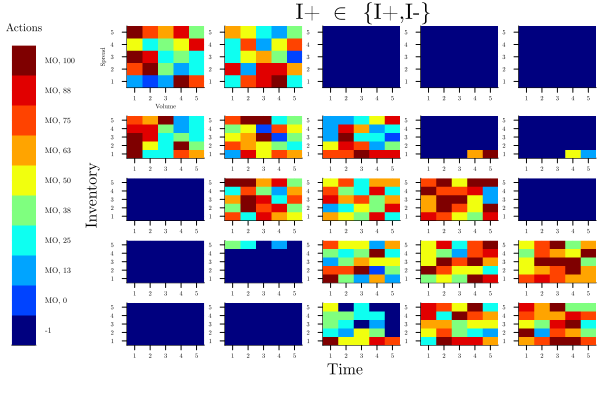

In [180]:
V_per_agent = Int(V / length(t1_b1_s1[1000]))
case = "I+,I-"
agent = "I+"
PolicyVisualization(t1_b1_s1[1000]["rlAgent_1"]["Q"], numT, I, B, W, A1, V_per_agent, actionsRL1, case, agent)


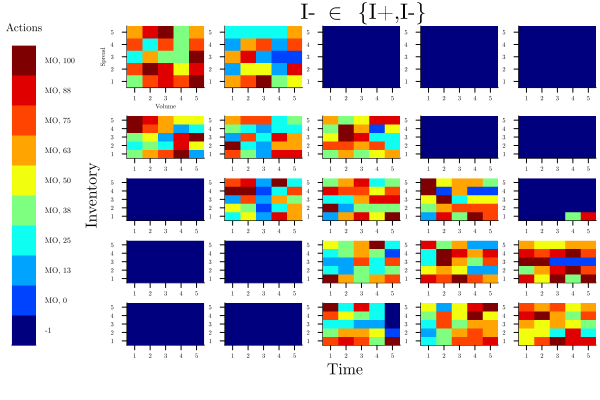

In [181]:
V_per_agent = Int(V / length(t1_b1_s1[1000]))
case = "I+,I-"
agent = "I-"
PolicyVisualization(t1_b1_s1[1000]["rlAgent_2"]["Q"], numT, I, B, W, A1, V_per_agent, actionsRL1, case, agent)


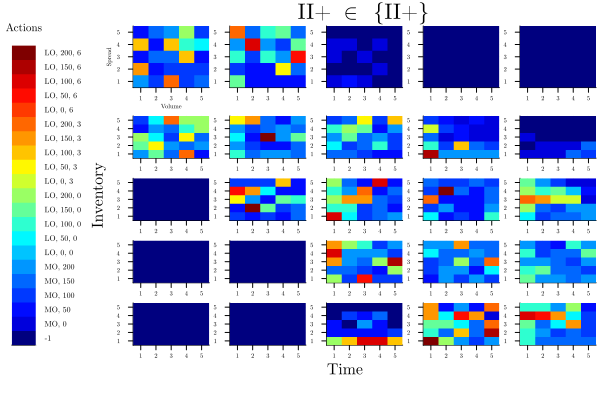

In [182]:
V_per_agent = Int(V / length(t2_b1_s0[1000]))
case = "II+"
agent = "II+"
PolicyVisualization(t2_b1_s0[1000]["rlAgent_1"]["Q"], numT, I, B, W, length(actionsRL2), V_per_agent, actionsRL2, case, agent)
